Импорты и инициализация Spark

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, lower, lit, count, isnan, regexp_replace
from pyspark.sql.types import DoubleType
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import shutil
import re

def get_spark_session():
    from pyspark.sql import SparkSession
    spark = SparkSession.builder \
        .appName("COVID19_Analytics") \
        .master("local[*]") \
        .getOrCreate()
    print("SparkSession успешно создана и запущена в локальном режиме")
    return spark

spark = get_spark_session()
sc = spark.sparkContext

SparkSession успешно создана и запущена в локальном режиме


Проверка и загрузка данных

In [2]:
LOCAL_CSV_PATH = "/home/jovyan/work/covid-chestxray-dataset-master/metadata.csv"

if not os.path.exists(LOCAL_CSV_PATH):
    raise FileNotFoundError(f"Файл {LOCAL_CSV_PATH} не найден")

local_csv_path = f"file://{LOCAL_CSV_PATH}"

metadata_df = spark.read.csv(local_csv_path, header=True, inferSchema=True)
print("Исходный датасет:")
metadata_df.show(5)

Исходный датасет:
+---------+------+---+---+--------------------+---------------+--------+---------+------------------+--------+------+----------------------+---------+-----------+--------------+---------------+----------------+----------------+----+--------+----------------+--------------------+------+--------------------+--------------------+--------------------+-------+--------------------+-----------+----+
|patientid|offset|sex|age|             finding|RT_PCR_positive|survival|intubated|intubation_present|went_icu|in_icu|needed_supplemental_O2|extubated|temperature|pO2_saturation|leukocyte_count|neutrophil_count|lymphocyte_count|view|modality|            date|            location|folder|            filename|                 doi|                 url|license|      clinical_notes|other_notes|_c29|
+---------+------+---+---+--------------------+---------------+--------+---------+------------------+--------+------+----------------------+---------+-----------+--------------+-------------

Анализ пропущенных значений

Подсчёт пропусков по столбцам

In [3]:
missing_counts = metadata_df.select([
    count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in metadata_df.columns
])
missing_counts.show(truncate=False)

+---------+------+---+---+-------+---------------+--------+---------+------------------+--------+------+----------------------+---------+-----------+--------------+---------------+----------------+----------------+----+--------+----+--------+------+--------+---+---+-------+--------------+-----------+----+
|patientid|offset|sex|age|finding|RT_PCR_positive|survival|intubated|intubation_present|went_icu|in_icu|needed_supplemental_O2|extubated|temperature|pO2_saturation|leukocyte_count|neutrophil_count|lymphocyte_count|view|modality|date|location|folder|filename|doi|url|license|clinical_notes|other_notes|_c29|
+---------+------+---+---+-------+---------------+--------+---------+------------------+--------+------+----------------------+---------+-----------+--------------+---------------+----------------+----------------+----+--------+----+--------+------+--------+---+---+-------+--------------+-----------+----+
|0        |253   |80 |237|0      |357            |589     |702      |700       

Визуализация пропусков

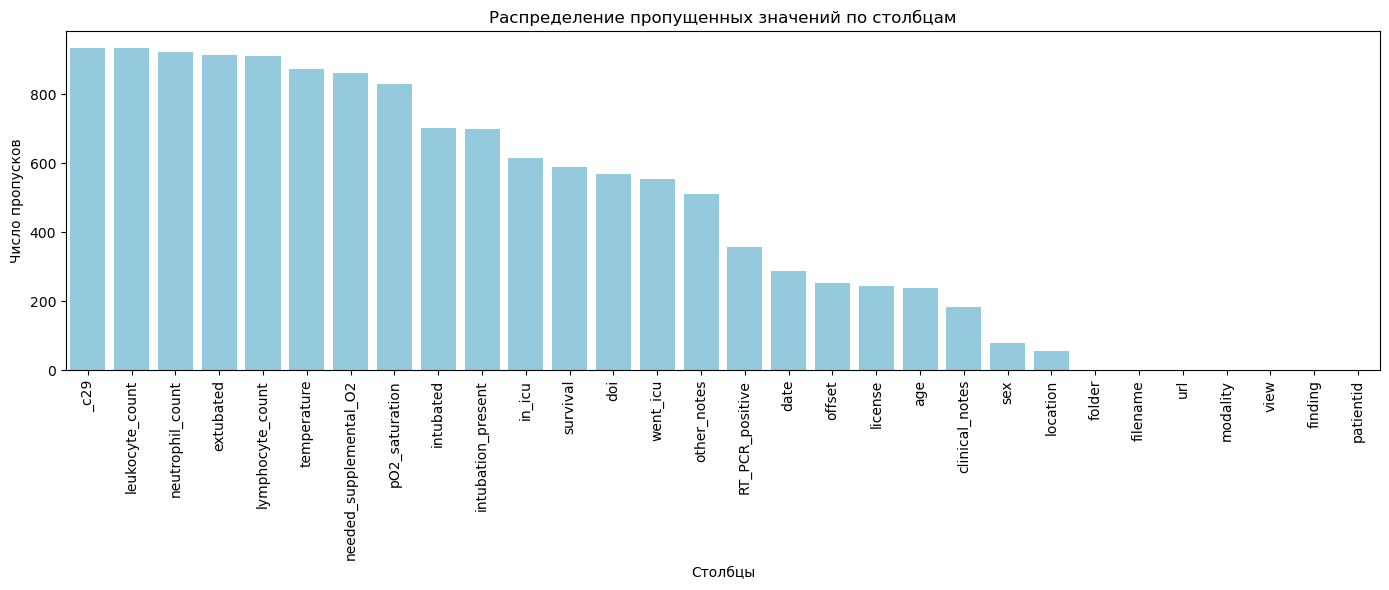

In [4]:
# Преобразование в Pandas DataFrame
missing_counts_pd = missing_counts.toPandas().T
missing_counts_pd.columns = ['missing_count']
missing_counts_pd.index.name = 'column'
missing_counts_pd.reset_index(inplace=True)

# Сортировка по количеству пропусков
missing_counts_pd = missing_counts_pd.sort_values(by='missing_count', ascending=False)

# График
plt.figure(figsize=(14, 6))
sns.barplot(data=missing_counts_pd, x='column', y='missing_count', color='skyblue')
plt.xticks(rotation=90)
plt.title('Распределение пропущенных значений по столбцам')
plt.ylabel('Число пропусков')
plt.xlabel('Столбцы')
plt.tight_layout()
plt.show()

Выявление аномальных значений

Аномалии возраста (age < 0 или age > 120)

In [5]:
# Фильтрация аномальных возрастов
age_outliers_df = metadata_df.filter((col("age") < 0) | (col("age") > 120))

# Вывод примера
age_outliers_df.select("patientid", "age").show()

# Общее количество аномалий
total_age_anomalies = age_outliers_df.count()
print(f"Количество аномальных записей с возрастом: {total_age_anomalies}")

+---------+---+
|patientid|age|
+---------+---+
+---------+---+

Количество аномальных записей с возрастом: 0


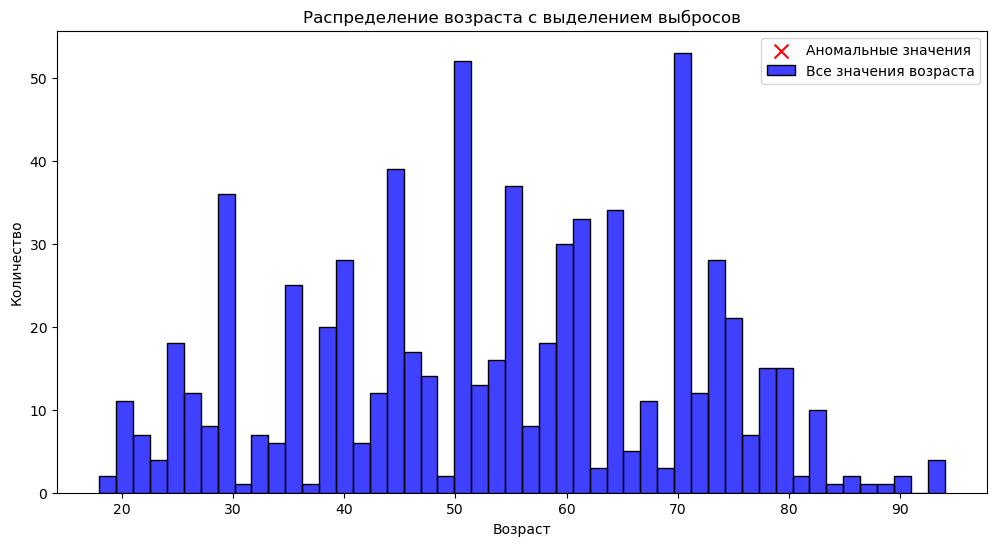

In [6]:
# Для визуализации преобразуем в Pandas
all_ages_pd = metadata_df.select("age").toPandas()
age_outliers_pd = age_outliers_df.select("age").toPandas()

# Гистограмма
plt.figure(figsize=(12, 6))
sns.histplot(all_ages_pd['age'].dropna(), bins=50, color='blue', label='Все значения возраста', kde=False)
plt.scatter(age_outliers_pd['age'], [0]*len(age_outliers_pd), color='red', label='Аномальные значения', marker='x', s=100)
plt.legend()
plt.title("Распределение возраста с выделением выбросов")
plt.xlabel("Возраст")
plt.ylabel("Количество")
plt.show()

Анализ диагнозов

In [7]:
metadata_df.select("finding").distinct().orderBy("finding").show(truncate=False)

+---------------------------------------+
|finding                                |
+---------------------------------------+
|No Finding                             |
|Pneumonia                              |
|Pneumonia/Aspiration                   |
|Pneumonia/Bacterial                    |
|Pneumonia/Bacterial/Chlamydophila      |
|Pneumonia/Bacterial/E.Coli             |
|Pneumonia/Bacterial/Klebsiella         |
|Pneumonia/Bacterial/Legionella         |
|Pneumonia/Bacterial/Mycoplasma         |
|Pneumonia/Bacterial/Nocardia           |
|Pneumonia/Bacterial/Staphylococcus/MRSA|
|Pneumonia/Bacterial/Streptococcus      |
|Pneumonia/Fungal/Aspergillosis         |
|Pneumonia/Fungal/Pneumocystis          |
|Pneumonia/Lipoid                       |
|Pneumonia/Viral/COVID-19               |
|Pneumonia/Viral/Herpes                 |
|Pneumonia/Viral/Influenza              |
|Pneumonia/Viral/Influenza/H1N1         |
|Pneumonia/Viral/MERS-CoV               |
+---------------------------------

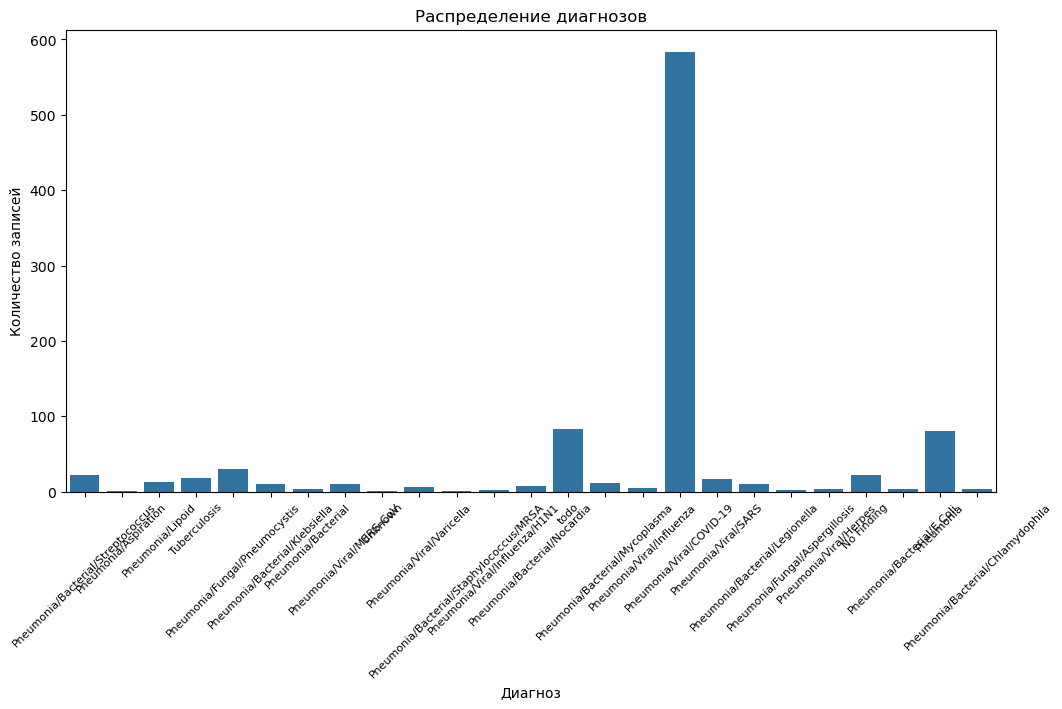

In [8]:
# Подсчёт частоты диагнозов
diagnosis_counts_pd = metadata_df.groupBy("finding").count().toPandas()

# График
plt.figure(figsize=(12,6))
sns.barplot(data=diagnosis_counts_pd, x='finding', y='count')
plt.xticks(rotation=45)
plt.tick_params(axis='x', labelsize=8)
plt.title("Распределение диагнозов")
plt.xlabel("Диагноз")
plt.ylabel("Количество записей")
plt.show()

Очистка данных

In [9]:
# Вычисляем медиану возраста
age_median = metadata_df.approxQuantile("age", [0.5], 0.01)[0]

# Добавляем новые колонки
metadata_df = metadata_df.withColumn(
    "age_filled",
    when(col("age").isNull(), lit(age_median)).otherwise(col("age"))
)
metadata_df = metadata_df.withColumn(
    "sex_filled",
    when(col("sex").isNull() | (col("sex") == ""), lit("Unknown")).otherwise(col("sex"))
)

# Унификация диагнозов
metadata_df = metadata_df.withColumn(
    "finding_unified",
    when(lower(col("finding")).rlike("covid"), lit("COVID-19"))
    .when(lower(col("finding")).rlike("pneumonia"), lit("Pneumonia"))
    .when(lower(col("finding")).rlike("sars"), lit("SARS"))
    .otherwise(lit("Other"))
)

# Удаление дубликатов
metadata_df = metadata_df.dropDuplicates()

# Аномалии возраста
metadata_df = metadata_df.withColumn(
    "age_cleaned",
    when((col("age") < 0) | (col("age") > 120), lit(age_median))
    .otherwise(col("age"))
)

# Возрастные группы
metadata_df = metadata_df.withColumn(
    "age_group",
    when(col("age_cleaned") < 18, "child")
     .when((col("age_cleaned") >= 18) & (col("age_cleaned") < 60), "adult")
     .otherwise("elderly")
)

Анализ качества данных и визуализация

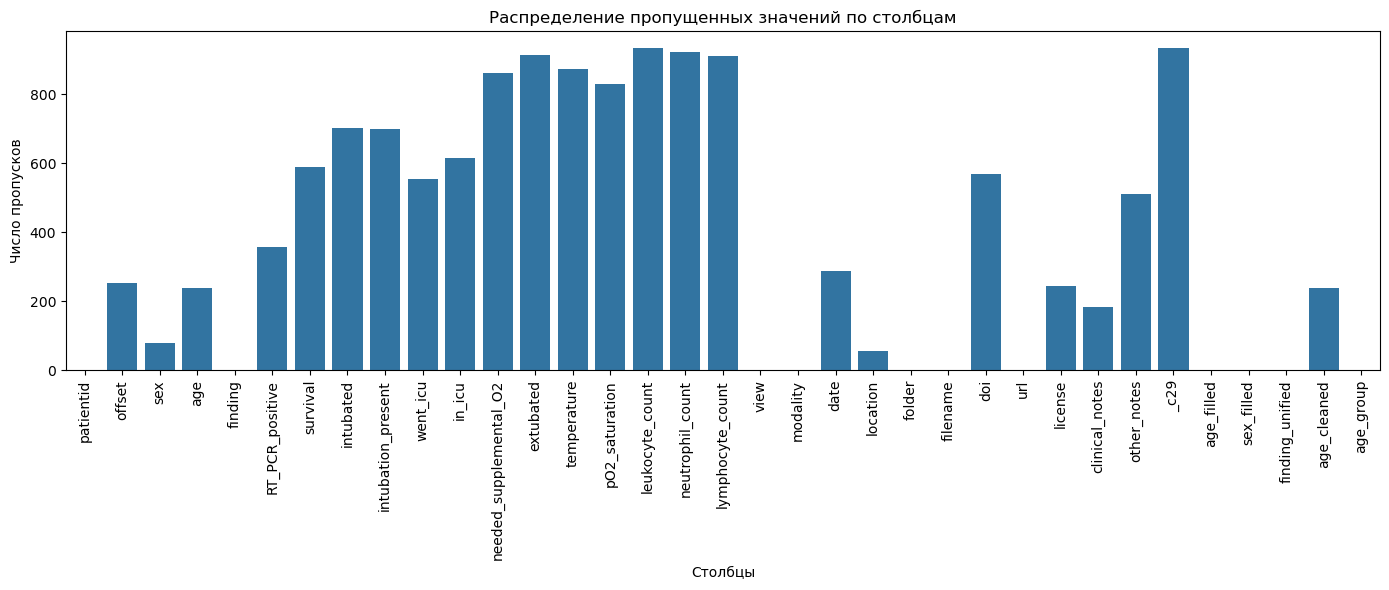

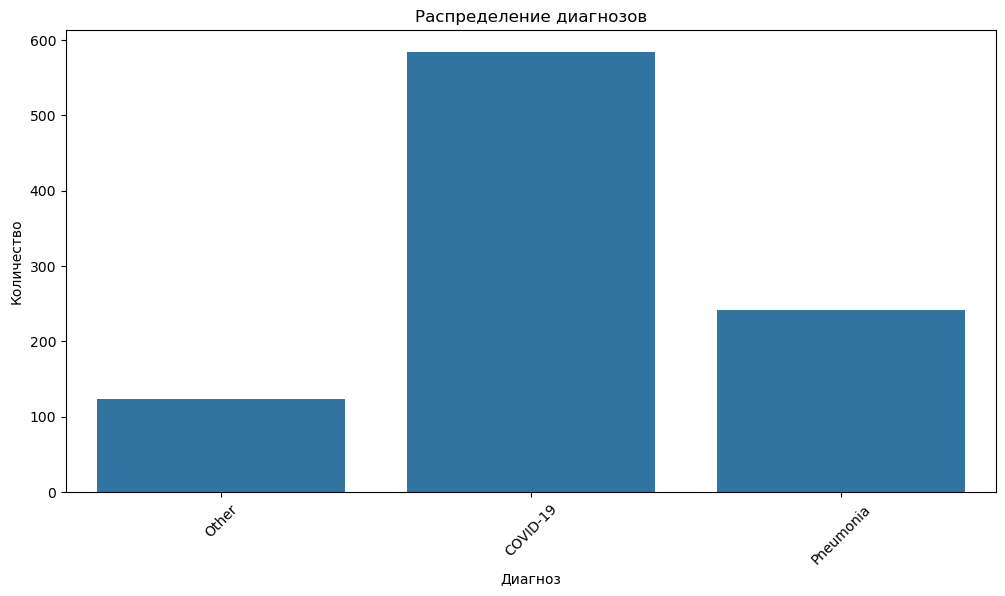

In [10]:
# Пропуски
missing_counts = metadata_df.select([
    count(when(col(c).isNull() | isnan(c) | (col(c) == ""), c)).alias(c)
    for c in metadata_df.columns
])
missing_counts_pd = missing_counts.toPandas().T
missing_counts_pd.columns = ['missing_count']
missing_counts_pd.index.name = 'column'
missing_counts_pd.reset_index(inplace=True)

plt.figure(figsize=(14, 6))
sns.barplot(data=missing_counts_pd, x='column', y='missing_count')
plt.xticks(rotation=90)
plt.title('Распределение пропущенных значений по столбцам')
plt.ylabel('Число пропусков')
plt.xlabel('Столбцы')
plt.tight_layout()
plt.show()

# Распределение диагнозов
diagnosis_counts = metadata_df.groupBy("finding_unified").count().toPandas()
plt.figure(figsize=(12, 6))
sns.barplot(data=diagnosis_counts, x='finding_unified', y='count')
plt.xticks(rotation=45)
plt.title("Распределение диагнозов")
plt.xlabel("Диагноз")
plt.ylabel("Количество")
plt.show()

В процессе анализа данных были выявлены существенные проблемы качества. Обнаружены многочисленные пропуски: в возрасте и поле, а также в клинических показателях, что потребует их заполнения медианой или специализированными значениями. Выявлены и обработаны аномальные значения возраста,заменены медианой, а также унифицированы разнообразные записи диагнозов для приведения их к стандартизированному виду. Кроме того, были удалены дублирующиеся записи, и отмечены случаи неполных данных и отсутствия метаинформации, что требует дальнейшего внимания для обеспечения надёжности анализа.

Копирование изображений по категориям

In [11]:
# Очистка папок для отладки
# Путь к папке с отсортированными изображениями
LOCAL_SORTED_IMAGES = "/home/jovyan/work/sorted_images"

# Удаляем содержимое подпапок, но не саму структуру
for category in ["covid", "pneumonia", "other"]:
    folder_path = os.path.join(LOCAL_SORTED_IMAGES, category)
    if os.path.exists(folder_path):
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f"Ошибка удаления {file_path}: {e}")
    else:
        os.makedirs(folder_path)

In [12]:
# Пути к директориям и файлам
LOCAL_IMAGES_DIR = "/home/jovyan/work/covid-chestxray-dataset-master/images"
SORTED_IMAGES_DIR = "/home/jovyan/work/sorted_images"
METADATA_CSV_PATH = "/home/jovyan/work/covid-chestxray-dataset-master/metadata.csv"

# Проверка, что файл метаданных существует локально
if not os.path.exists(METADATA_CSV_PATH):
    raise FileNotFoundError(f"Файл {METADATA_CSV_PATH} не найден")

# Для корректного чтения локального файла добавим file://
local_csv_path = f"file://{METADATA_CSV_PATH}"

# Чтение CSV в DataFrame Spark с автоподбором схемы и заголовком
metadata_df = spark.read.csv(local_csv_path, header=True, inferSchema=True)

# Унификация диагнозов в новую колонку: covid, pneumonia или other
metadata_df = metadata_df.withColumn(
    "finding_unified",
    when(lower(col("finding")).rlike("covid"), lit("covid"))
     .when(lower(col("finding")).rlike("pneumonia"), lit("pneumonia"))
     .otherwise(lit("other"))
)

# Переводим необходимые колонки в pandas для удобной работы с файлами
metadata_pd = metadata_df.select("filename", "finding_unified").toPandas()

# Создаем директории для отсортированных изображений, если их нет
os.makedirs(os.path.join(SORTED_IMAGES_DIR, "covid"), exist_ok=True)
os.makedirs(os.path.join(SORTED_IMAGES_DIR, "pneumonia"), exist_ok=True)
os.makedirs(os.path.join(SORTED_IMAGES_DIR, "other"), exist_ok=True)

# Счётчики для статистики копирования
copied_count = {"covid": 0, "pneumonia": 0, "other": 0}
skipped_count = {"covid": 0, "pneumonia": 0, "other": 0}

# Итерация по строкам метаданных и копирование изображений по категориям
for _, row in metadata_pd.iterrows():
    filename = row["filename"]
    category = row["finding_unified"].lower()

    src_path = os.path.join(LOCAL_IMAGES_DIR, filename)
    if not os.path.exists(src_path):
        # Если файла не существует в исходной папке, пропускаем
        continue

    dest_dir = os.path.join(SORTED_IMAGES_DIR, category)
    dest_path = os.path.join(dest_dir, filename)

    if os.path.exists(dest_path):
        # Файл уже скопирован, считаем как пропущенный
        skipped_count[category] += 1
        continue

    shutil.copy2(src_path, dest_dir)
    copied_count[category] += 1

# Выводим статистику успешной обработки
print("\nИзображения успешно обработаны:")
for cat in ["covid", "pneumonia", "other"]:
    total = copied_count[cat] + skipped_count[cat]
    print(f"{cat.capitalize()}: {copied_count[cat]} новых / {total} всего")

total_copied = sum(copied_count.values())
total_skipped = sum(skipped_count.values())
print(f"\nВсего обработано: {total_copied + total_skipped}")
print(f"Успешно скопировано: {total_copied}")
print(f"Пропущено (уже скопировано): {total_skipped}")

# В конце можно завершить сессию Spark, если больше не планируется использовать её
# spark.stop()


Изображения успешно обработаны:
Covid: 563 новых / 563 всего
Pneumonia: 242 новых / 242 всего
Other: 124 новых / 124 всего

Всего обработано: 929
Успешно скопировано: 929
Пропущено (уже скопировано): 0


In [13]:
# Папка для сохранения
target_dir = "/home/jovyan/work/metadata"
os.makedirs(target_dir, exist_ok=True)

# Пути с префиксом file:// для локального сохранения
csv_path = "file://" + os.path.join(target_dir, "metadata_cleaned_csv")
parquet_path = "file://" + os.path.join(target_dir, "metadata_cleaned.parquet")

# Сохраняем в CSV (один файл с заголовком)
metadata_df.coalesce(1).write \
    .mode("overwrite") \
    .option("header", "true") \
    .csv(csv_path)

# Сохраняем в Parquet
metadata_df.write \
    .mode("overwrite") \
    .parquet(parquet_path)

print(f"DataFrame сохранён в:\n- CSV каталог: {csv_path}\n- Parquet каталог: {parquet_path}")

DataFrame сохранён в:
- CSV каталог: file:///home/jovyan/work/metadata/metadata_cleaned_csv
- Parquet каталог: file:///home/jovyan/work/metadata/metadata_cleaned.parquet


Сохранение в HDFS

In [14]:
def get_spark_session_hdfs():
    global spark  # Чтобы работать с глобальной переменной spark
    try:
        spark
        spark_exists = True
    except NameError:
        spark_exists = False

    if spark_exists:
        print("Существующая SparkSession найдена, останавливаем её...")
        spark.stop()

    spark = SparkSession.builder \
        .appName("COVID19_Analytics") \
        .config("spark.hadoop.fs.defaultFS", "hdfs://namenode:9000") \
        .config("spark.sql.warehouse.dir", "hdfs://namenode:9000/user/jovyan/warehouse") \
        .enableHiveSupport() \
        .getOrCreate()
    print("SparkSession успешно создана и запущена с поддержкой HDFS")
    return spark

spark = get_spark_session_hdfs()
sc = spark.sparkContext

Существующая SparkSession найдена, останавливаем её...
SparkSession успешно создана и запущена с поддержкой HDFS


In [17]:
import os

sc = spark.sparkContext

# 1. Определяем пути
HDFS_PATHS = {
    'base': '/user/jovyan/covid_dataset',
    'images': '/user/jovyan/covid_dataset/images',
    'metadata': '/user/jovyan/covid_dataset/metadata',
    'processed': '/user/jovyan/covid_dataset/processed'
}

LOCAL_PATHS = {
    'sorted_images': '/home/jovyan/work/sorted_images',
    'metadata_parquet': '/home/jovyan/work/metadata/metadata_cleaned.parquet'
}

# 2. Функция получения HDFS FileSystem с настройкой fs.defaultFS
def get_hdfs():
    hadoop = sc._jvm.org.apache.hadoop
    conf = sc._jsc.hadoopConfiguration()
    conf.set("fs.defaultFS", "hdfs://namenode:9000")  # важный момент
    return hadoop.fs.FileSystem.get(conf)

# 3. Функции для работы с HDFS
def hdfs_exists(path):
    fs = get_hdfs()
    return fs.exists(sc._jvm.org.apache.hadoop.fs.Path(path))

def hdfs_mkdir(path):
    fs = get_hdfs()
    p = sc._jvm.org.apache.hadoop.fs.Path(path)
    if not fs.exists(p):
        fs.mkdirs(p)
        print(f"Создана директория в HDFS: {path}")
    else:
        print(f"Директория в HDFS уже существует: {path}")

def hdfs_put(local_path, hdfs_path):
    fs = get_hdfs()
    src = sc._jvm.org.apache.hadoop.fs.Path(f"file://{local_path}")  # локальный путь — с file://
    dst = sc._jvm.org.apache.hadoop.fs.Path(hdfs_path)
    fs.copyFromLocalFile(False, True, src, dst)
    print(f"Скопирован файл {local_path} в HDFS {hdfs_path}")

# 4. Создаём структуру HDFS
for path in HDFS_PATHS.values():
    hdfs_mkdir(path)

# 5. Сохраняем metadata_df в parquet на локальном FS, затем копируем в HDFS по файлам
local_meta_dir = LOCAL_PATHS['metadata_parquet']

# Сам parquet — папка с файлами part-*, копируем рекурсивно
hdfs_meta_dir = HDFS_PATHS['metadata']
hdfs_mkdir(hdfs_meta_dir)

copy_local_dir = local_meta_dir  # локальный путь к parquet, убедитесь что он существует

# Копируем parquet папку как есть (рекурсивно)
fs = get_hdfs()
src_path = sc._jvm.org.apache.hadoop.fs.Path(f"file://{copy_local_dir}")
dst_path = sc._jvm.org.apache.hadoop.fs.Path(hdfs_meta_dir)
fs.copyFromLocalFile(False, True, src_path, dst_path)
print(f"Метаданные (Parquet) скопированы из {copy_local_dir} в HDFS {hdfs_meta_dir}")

# 6. Загружаем изображения по файлам
for category in ['covid', 'pneumonia', 'other']:
    local_cat_dir = os.path.join(LOCAL_PATHS['sorted_images'], category)
    hdfs_cat_dir = f"{HDFS_PATHS['images']}/{category}"
    hdfs_mkdir(hdfs_cat_dir)

    if not os.path.exists(local_cat_dir):
        print(f"Локальная папка {local_cat_dir} не найдена, пропускаем")
        continue

    files = os.listdir(local_cat_dir)
    if not files:
        print(f"Папка {local_cat_dir} пуста, пропускаем")
        continue

    for i, filename in enumerate(files, 1):
        local_file_path = os.path.join(local_cat_dir, filename)
        hdfs_file_path = f"{hdfs_cat_dir}/{filename}"
        hdfs_put(local_file_path, hdfs_file_path)
        if i % 100 == 0 or i == len(files):
            print(f"Загружено {i}/{len(files)} файлов в {hdfs_cat_dir}")

# 7. Подсчёт и вывод статистики локальных изображений (по категориям)
def count_files(path):
    return len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]) if os.path.exists(path) else 0

print("\nКоличество локальных изображений по категориям:")
total_images = 0
for cat in ['covid', 'pneumonia', 'other']:
    cat_path = os.path.join(LOCAL_PATHS['sorted_images'], cat)
    c = count_files(cat_path)
    print(f"{cat.capitalize()}: {c} файлов")
    total_images += c
print(f"Всего изображений: {total_images}")

Директория в HDFS уже существует: /user/jovyan/covid_dataset
Директория в HDFS уже существует: /user/jovyan/covid_dataset/images
Директория в HDFS уже существует: /user/jovyan/covid_dataset/metadata
Директория в HDFS уже существует: /user/jovyan/covid_dataset/processed
Директория в HDFS уже существует: /user/jovyan/covid_dataset/metadata
Метаданные (Parquet) скопированы из /home/jovyan/work/metadata/metadata_cleaned.parquet в HDFS /user/jovyan/covid_dataset/metadata
Создана директория в HDFS: /user/jovyan/covid_dataset/images/covid
Скопирован файл /home/jovyan/work/sorted_images/covid/2eadbbb367a0366d8c34350d083a83_jumbo.jpeg в HDFS /user/jovyan/covid_dataset/images/covid/2eadbbb367a0366d8c34350d083a83_jumbo.jpeg
Скопирован файл /home/jovyan/work/sorted_images/covid/483f2ad8.jpg в HDFS /user/jovyan/covid_dataset/images/covid/483f2ad8.jpg
Скопирован файл /home/jovyan/work/sorted_images/covid/thnov10p5641g006-c.png в HDFS /user/jovyan/covid_dataset/images/covid/thnov10p5641g006-c.png
Ско

In [ ]:
SQL-аналитика

In [21]:
print("Текущий spark.sql.warehouse.dir:", spark.conf.get("spark.sql.warehouse.dir"))


Текущий spark.sql.warehouse.dir: hdfs://namenode:9000/user/jovyan/warehouse


In [23]:
import pyspark.sql.functions as F

# 1. Читаем Parquet из HDFS с учётом пути кластера
df = spark.read.parquet("hdfs://namenode:9000/user/jovyan/covid_dataset/metadata/metadata_cleaned.parquet")

# 2. Подготовка данных с добавлением колонок и преобразованием
df_prepared = df \
    .withColumn("patientid", F.col("patientid").cast("int")) \
    .withColumn("sex_filled", F.coalesce(F.col("sex"), F.lit("Unknown"))) \
    .withColumn("age_cleaned", F.col("age").cast("double")) \
    .withColumn("finding_unified", F.lower(F.regexp_replace(F.col("finding"), "\\s*/\\s*|\\s+", "_"))) \
    .select(
        "patientid",
        "filename",
        "age_cleaned",
        "sex_filled",
        "finding_unified",
        "clinical_notes"
    )

# 3. Создаем базу данных и переключаемся на неё
spark.sql("CREATE DATABASE IF NOT EXISTS covid_db")
spark.sql("USE covid_db")

# 4. Удаляем старые таблицы при их наличии
spark.sql("DROP TABLE IF EXISTS covid_patients_optimized")
spark.sql("DROP TABLE IF EXISTS patient_outcomes")

# 5. Создаем таблицу с партиционированием и бакетированием
spark.sql("""
CREATE TABLE covid_patients_optimized (
    patientid INT,
    filename STRING,
    age_cleaned DOUBLE,
    sex_filled STRING,
    clinical_notes STRING
)
PARTITIONED BY (finding_unified STRING)
CLUSTERED BY (patientid) INTO 8 BUCKETS
STORED AS PARQUET
TBLPROPERTIES (
    'parquet.compression'='SNAPPY',
    'auto.purge'='true'
)
""")

# 6. Создаем еще одну таблицу для итогов с бакетированием
spark.sql("""
CREATE TABLE patient_outcomes (
    patientid INT,
    outcome STRING,
    days_hospitalized INT,
    severity STRING
)
CLUSTERED BY (patientid) INTO 8 BUCKETS
STORED AS PARQUET
""")

# 7. Записываем подготовленные данные в таблицу, учитывая партиционирование и бакетирование
df_prepared.write \
    .mode("overwrite") \
    .partitionBy("finding_unified") \
    .bucketBy(8, "patientid") \
    .sortBy("patientid") \
    .saveAsTable("covid_patients_optimized")

# Примерные данные для patient_outcomes (с искусственными данными) 
outcome_data = [
    (1, "recovered", 10, "mild"),
    (2, "recovered", 14, "moderate"),
    (3, "deceased", 21, "severe"),
    (4, "recovered", 7, "mild"),
    (5, "deceased", 28, "critical")
]

spark.createDataFrame(outcome_data, ["patientid", "outcome", "days_hospitalized", "severity"]) \
    .write.mode("overwrite") \
    .bucketBy(8, "patientid") \
    .sortBy("patientid") \
    .saveAsTable("patient_outcomes")

# 8. Примеры аналитических запросов

print("1. Оконная функция с партиционированием по диагнозу:")
spark.sql("""
SELECT 
    patientid,
    finding_unified,
    age_cleaned,
    AVG(age_cleaned) OVER (
        PARTITION BY finding_unified
        ORDER BY patientid
        ROWS BETWEEN 1 PRECEDING AND 1 FOLLOWING
    ) AS moving_avg_age,
    COUNT(*) OVER (PARTITION BY finding_unified) AS patients_in_diagnosis
FROM covid_patients_optimized
WHERE finding_unified IS NOT NULL
LIMIT 20
""").show(truncate=False)

print("\n2. JOIN между бакетированными таблицами:")
spark.sql("""
SELECT 
    c.patientid,
    c.finding_unified AS diagnosis,
    c.age_cleaned,
    p.outcome,
    p.days_hospitalized,
    p.severity,
    CASE 
        WHEN p.outcome = 'deceased' THEN 'high'
        WHEN c.age_cleaned > 60 THEN 'medium'
        ELSE 'low'
    END AS risk_level
FROM covid_patients_optimized c
JOIN patient_outcomes p ON c.patientid = p.patientid
ORDER BY p.days_hospitalized DESC
LIMIT 10
""").show(truncate=False)

print("\n3. Аналитический подзапрос с агрегацией:")
spark.sql("""
SELECT 
    c.finding_unified,
    COUNT(*) AS patients_count,
    ROUND(AVG(c.age_cleaned), 1) AS avg_age,
    (SELECT COUNT(*) FROM patient_outcomes WHERE outcome = 'deceased') AS total_deceased,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM covid_patients_optimized), 2) AS percentage
FROM covid_patients_optimized c
GROUP BY c.finding_unified
HAVING COUNT(*) > 5
ORDER BY patients_count DESC
LIMIT 10
""").show(truncate=False)

# 9. (Опционально) Завершение сессии Spark - если необходимо
# spark.stop()


1. Оконная функция с партиционированием по диагнозу:
+---------+---------------+-----------+------------------+---------------------+
|patientid|finding_unified|age_cleaned|moving_avg_age    |patients_in_diagnosis|
+---------+---------------+-----------+------------------+---------------------+
|NULL     |no_finding     |75.0       |68.0              |22                   |
|38       |no_finding     |61.0       |65.66666666666667 |22                   |
|38       |no_finding     |61.0       |64.0              |22                   |
|173      |no_finding     |70.0       |52.666666666666664|22                   |
|210      |no_finding     |27.0       |45.333333333333336|22                   |
|211      |no_finding     |39.0       |36.333333333333336|22                   |
|214      |no_finding     |43.0       |34.666666666666664|22                   |
|217      |no_finding     |22.0       |34.666666666666664|22                   |
|218      |no_finding     |39.0       |33.33333333333333

Фильтрация снимков по диагнозу и сохранение в Parquet

In [25]:
# --- 1. Фильтрация пациентов с диагнозом COVID-19 ---
covid_df = df.filter(F.lower(F.col("finding")).like("%covid%"))
covid_df.write.mode("overwrite") \
    .parquet("hdfs://namenode:9000/user/jovyan/covid_dataset/filtered/covid_only")
print("Сохранен отфильтрованный набор пациентов с диагнозом COVID-19.")

Сохранен отфильтрованный набор пациентов с диагнозом COVID-19.


Обработка в PySpark

In [26]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import StringType
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.sql.window import Window

# Инициализация SparkSession с Hive и указанием warehouse в HDFS
spark = SparkSession.builder \
    .appName("CovidProcessing") \
    .config("spark.sql.warehouse.dir", "hdfs://namenode:9000/user/jovyan/warehouse") \
    .enableHiveSupport() \
    .getOrCreate()

# Пути
HDFS_METADATA_PARQUET_PATH = "hdfs://namenode:9000/user/jovyan/covid_dataset/metadata/metadata_cleaned.parquet"
HDFS_FILTERED_COVID_PATH = "hdfs://namenode:9000/user/jovyan/covid_dataset/filtered/covid_only"
HDFS_ML_OUTPUT_PATH = "hdfs://namenode:9000/user/jovyan/covid_dataset/ml/clustered"

# --- 1. Читаем полный датасет из Parquet в HDFS ---
df = spark.read.parquet(HDFS_METADATA_PARQUET_PATH)

# --- 2. Фильтрация пациентов с диагнозом COVID-19 и сохранение ---
covid_df = df.filter(F.lower(F.col("finding")).like("%covid%"))
covid_df.write.mode("overwrite").parquet(HDFS_FILTERED_COVID_PATH)
print("Сохранен отфильтрованный набор пациентов с диагнозом COVID-19.")

# --- 3. UDF для унификации диагнозов и категоризации возраста ---

def unify_finding(finding):
    if finding is None:
        return "unknown"
    finding_low = finding.lower()
    if "covid" in finding_low:
        return "covid-19"
    elif "pneumonia" in finding_low:
        return "pneumonia"
    else:
        return "other"

def categorize_age(age):
    if age is None:
        return "unknown"
    elif age < 30:
        return "young"
    elif 30 <= age <= 60:
        return "middle"
    else:
        return "old"

unify_finding_udf = F.udf(unify_finding, StringType())
categorize_age_udf = F.udf(categorize_age, StringType())

df_enriched = df \
    .withColumn("finding_unified", unify_finding_udf(F.col("finding"))) \
    .withColumn("age_category", categorize_age_udf(F.col("age").cast("double")))

df_enriched.select("finding", "finding_unified", "age", "age_category").show(10, truncate=False)

# --- 4. ML: Кластеризация пациентов по возрасту и полу ---

# Кодируем пол (sex) в числовой индекс
sex_indexer = StringIndexer(inputCol="sex", outputCol="sex_index", handleInvalid="keep")
df_ml = sex_indexer.fit(df_enriched).transform(df_enriched)

# Заполняем пропущенное значение возраста средним, чтобы кластеризация не падала
avg_age = df_ml.select(F.avg(F.col("age").cast("double"))).first()[0]
df_ml_filled = df_ml.withColumn("age_filled",
                                F.when(F.col("age").isNull(), avg_age)
                                 .otherwise(F.col("age").cast("double")))

# Создаем вектор признаков
assembler = VectorAssembler(inputCols=["age_filled", "sex_index"], outputCol="features")
df_features = assembler.transform(df_ml_filled)

# Обучаем KMeans
kmeans = KMeans(featuresCol="features", k=3, seed=42)
model = kmeans.fit(df_features)

# Добавляем предсказания (кластеры) к исходным данным
df_predictions = model.transform(df_features)

# Показываем простой вывод результатов кластеризации
print("Результаты кластеризации (первые 20 строк):")
df_predictions.select("patientid", "age", "sex", "prediction").show(20, truncate=False)

# --- Дополнительно: Анализ распределения по кластерам ---

print("Количество пациентов в каждом кластере:")
df_predictions.groupBy("prediction").count().orderBy("prediction").show()

print("Средний и медианный возраст в каждом кластере:")
df_predictions.groupBy("prediction") \
    .agg(
        F.count("*").alias("count"),
        F.avg("age").alias("avg_age"),
        F.expr("percentile_approx(age, 0.5)").alias("median_age")
    ).orderBy("prediction").show()

print("Распределение пола в кластерах:")
df_predictions.groupBy("prediction", "sex").count().orderBy("prediction", "sex").show()

# --- Анализ популярных диагнозов в кластерах ---

window = Window.partitionBy("prediction").orderBy(F.desc("count"))

diag_counts = df_predictions.groupBy("prediction", "finding_unified") \
    .count() \
    .withColumn("rank", F.row_number().over(window)) \
    .filter(F.col("rank") <= 5) \
    .orderBy("prediction", "rank")

print("Топ-5 диагностик по кластерам:")
diag_counts.show(truncate=False)

# --- Сохраняем результат кластеризации в parquet в HDFS ---
df_predictions.write.mode("overwrite").parquet(HDFS_ML_OUTPUT_PATH)
print("Кластеризация завершена и сохранена.")


Сохранен отфильтрованный набор пациентов с диагнозом COVID-19.
+------------------------+---------------+----+------------+
|finding                 |finding_unified|age |age_category|
+------------------------+---------------+----+------------+
|Pneumonia/Viral/COVID-19|covid-19       |65  |old         |
|Pneumonia/Viral/COVID-19|covid-19       |65  |old         |
|Pneumonia/Viral/COVID-19|covid-19       |65  |old         |
|Pneumonia/Viral/COVID-19|covid-19       |65  |old         |
|Pneumonia/Viral/COVID-19|covid-19       |52  |middle      |
|Pneumonia/Viral/COVID-19|covid-19       |52  |middle      |
|Pneumonia               |pneumonia      |NULL|unknown     |
|Pneumonia/Viral/COVID-19|covid-19       |NULL|unknown     |
|Pneumonia/Viral/COVID-19|covid-19       |NULL|unknown     |
|Pneumonia/Viral/SARS    |pneumonia      |74  |old         |
+------------------------+---------------+----+------------+
only showing top 10 rows

Результаты кластеризации (первые 20 строк):
+---------+--

In [27]:
df = spark.read.parquet(HDFS_METADATA_PARQUET_PATH)
print(df.columns)  # Выведет список столбцов
df.printSchema()   # Выведет схему с типами столбцов
df.show(5)         # Покажет первые 5 строк таблицы

['patientid', 'offset', 'sex', 'age', 'finding', 'RT_PCR_positive', 'survival', 'intubated', 'intubation_present', 'went_icu', 'in_icu', 'needed_supplemental_O2', 'extubated', 'temperature', 'pO2_saturation', 'leukocyte_count', 'neutrophil_count', 'lymphocyte_count', 'view', 'modality', 'date', 'location', 'folder', 'filename', 'doi', 'url', 'license', 'clinical_notes', 'other_notes', '_c29', 'finding_unified']
root
 |-- patientid: string (nullable = true)
 |-- offset: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- finding: string (nullable = true)
 |-- RT_PCR_positive: string (nullable = true)
 |-- survival: string (nullable = true)
 |-- intubated: string (nullable = true)
 |-- intubation_present: string (nullable = true)
 |-- went_icu: string (nullable = true)
 |-- in_icu: string (nullable = true)
 |-- needed_supplemental_O2: string (nullable = true)
 |-- extubated: string (nullable = true)
 |-- temperature: double (nullable = tr

In [28]:
pip install panel hvplot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 12.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.3/170.3 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 28.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.3/260.3 kB 5.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 21.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.0/119.0 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.2/326.2 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.7/374.7 kB 10.8 MB/s eta 0:00:00
  Attemptin

In [29]:
import pyspark.sql.functions as F

# Читаем parquet с вашими данными
df = spark.read.parquet(HDFS_METADATA_PARQUET_PATH)

# Группируем по unified диагнозам, считаем количество
finding_counts = df.groupBy("finding_unified") \
    .count() \
    .orderBy(F.desc("count"))

# Для гистограммы возраста
age_data = df.select("age").filter(F.col("age").isNotNull())

# Для распределения пола
sex_counts = df.groupBy("sex").count()

# Превращаем в Pandas для визуализации (объемом выборок обычно нужно следить, чтобы не перегружать память)
pd_finding = finding_counts.toPandas()
pd_age = age_data.toPandas()
pd_sex = sex_counts.toPandas()


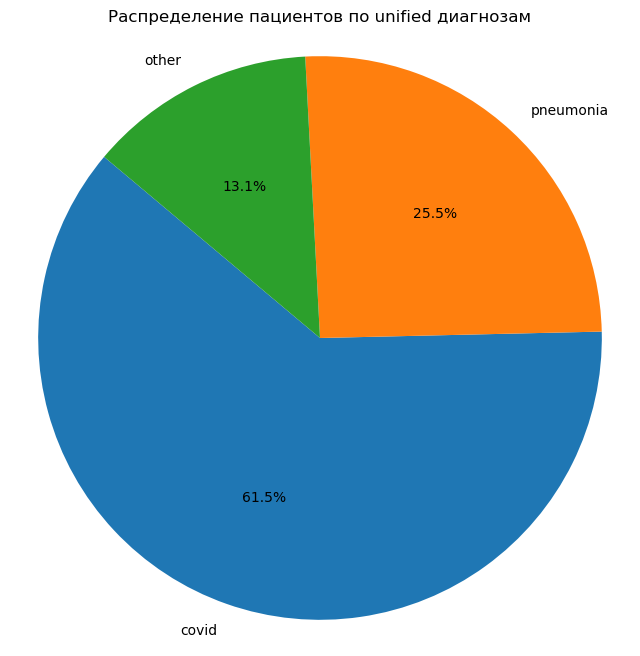

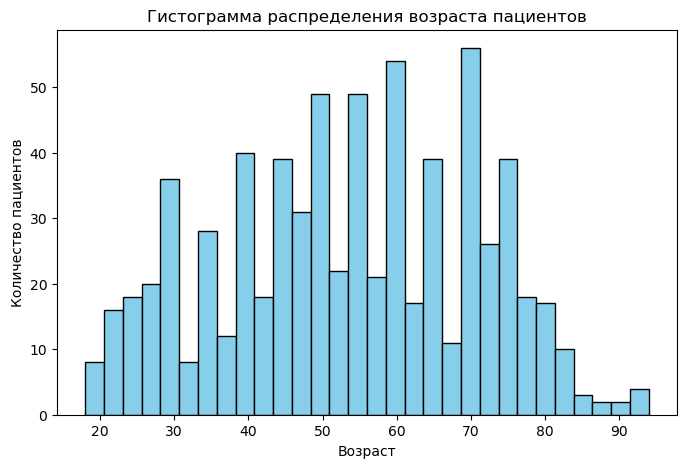

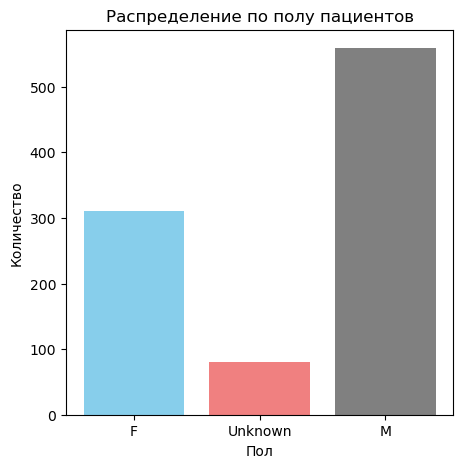

In [30]:
import matplotlib.pyplot as plt

# Круговая диаграмма распределения диагнозов (finding_unified)
plt.figure(figsize=(8,8))
plt.pie(pd_finding['count'], labels=pd_finding['finding_unified'], autopct='%1.1f%%', startangle=140)
plt.title("Распределение пациентов по unified диагнозам")
plt.axis('equal')  # Круговая
plt.show()

# Гистограмма возраста
plt.figure(figsize=(8,5))
plt.hist(pd_age['age'], bins=30, color='skyblue', edgecolor='black')
plt.title("Гистограмма распределения возраста пациентов")
plt.xlabel("Возраст")
plt.ylabel("Количество пациентов")
plt.show()

# Заменяем пропуски в 'sex' на строку 'Unknown'
pd_sex['sex'] = pd_sex['sex'].fillna('Unknown')

plt.figure(figsize=(5,5))
plt.bar(pd_sex['sex'], pd_sex['count'], color=['skyblue', 'lightcoral', 'gray'])
plt.title("Распределение по полу пациентов")
plt.xlabel("Пол")
plt.ylabel("Количество")
plt.show()

# Проект: Аналитическая платформа для мониторинга COVID-19

## Описание
Этот проект предназначен для анализа рентгеновских снимков пациентов с диагнозами COVID-19, пневмонии и других заболеваний.

## Технологии
- Hadoop (HDFS)
- Apache Spark
- PySpark
- Docker

## Установка
1. Запустите контейнеры: `docker-compose up -d`
2. Загрузите датасет covid-chestxray-dataset-master/`
3. Добавить файлы шрифта в рабочую папку (DBproject)4. 
5. Запустите Python-ячейки по порядку

## Необходимые права:
1. Создать каталоги для данных пользователей
hdfs dfs -mkdir -p /user/jovyan/covid_dataset/images
hdfs dfs -mkdir -p /user/jovyan/covid_dataset/metadata
hdfs dfs -mkdir -p /user/jovyan/covid_dataset/processed

2. Установить владельца каталогов на пользователя jovyan
hdfs dfs -chown -R jovyan:jovyan /user/jovyan/covid_dataset

3. Установить права доступа 775 (rwxrwxr-x) рекурсивно
hdfs dfs -chmod -R 775 /user/jovyan/covid_dataset

4. Единожды установить максимальные права для тестирования (возможно, позже уменьшите)
hdfs dfs -chmod -R 777 /user/jovyan/covid_dataset

5. Проверить наличие каталога /user/hive (скорее всего отсутствует)
hdfs dfs -ls /user/hive

6. Проверить наличие каталога /user/hive/warehouse
hdfs dfs -ls /user/hive/warehouse

7. Создать каталог warehouse в нужном месте, согласно настройкам Spark
hdfs dfs -mkdir -p /user/jovyan/warehouse

8. Установить владельца на jovyan
hdfs dfs -chown -R jovyan:jovyan /user/jovyan/warehouse

9. Установить права доступа 775 для warehouse
hdfs dfs -chmod -R 775 /user/jovyan/warehouse


## Структура
- DBHW.ipynb
- docker-compose.yml
- LiberationSans.ttf Для вывода отчета на русском языке
-/home/user/DBproject/

In [32]:
pip install reportlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 4.0 MB/s eta 0:00:0000:0100:010m
Note: you may need to restart the kernel to use updated packages.


In [33]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, isnan
import pandas as pd

# --- 1. Инициализация Spark ---
spark = SparkSession.builder \
    .appName("PDF_Report_Generator") \
    .config("spark.sql.warehouse.dir", "hdfs://namenode:9000/user/jovyan/warehouse") \
    .enableHiveSupport() \
    .getOrCreate()

# --- 2. Пути к данным в HDFS ---
HDFS_METADATA_PATH = "hdfs://namenode:9000/user/jovyan/covid_dataset/metadata/metadata_cleaned.parquet"
HDFS_ML_PATH = "hdfs://namenode:9000/user/jovyan/covid_dataset/ml/clustered"

# --- 3. Чтение данных ---
df_metadata = spark.read.parquet(HDFS_METADATA_PATH)
df_ml = spark.read.parquet(HDFS_ML_PATH)

# --- 4. Анализ пропусков ---
missing_counts = df_metadata.select([
    count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in df_metadata.columns
])
missing_counts_pd = missing_counts.toPandas().T
missing_counts_pd.columns = ['missing_count']
missing_counts_pd.index.name = 'column'
missing_counts_pd = missing_counts_pd.reset_index().sort_values(by='missing_count', ascending=False)

print("Пропуски по столбцам:")
print(missing_counts_pd)

# --- 5. Подсчёт диагнозов ---
if "finding_unified" in df_metadata.columns:
    diag_counts_pd = df_metadata.groupBy("finding_unified").count().toPandas()
    print("Диагнозы и их количество:")
    print(diag_counts_pd.head())
else:
    print("Столбец 'finding_unified' отсутствует в df_metadata")

# --- 6. Подсчёт по полу ---
if "sex" in df_metadata.columns:
    gender_counts_pd = df_metadata.groupBy("sex").count().toPandas()
    print("Распределение по полу:")
    print(gender_counts_pd.head())
else:
    print("Столбец 'sex' отсутствует в df_metadata")

# --- 7. Подсчёт по кластерам (если есть нужные столбцы) ---
required_columns = {"prediction", "finding_unified"}
if required_columns.issubset(set(df_ml.columns)):
    cluster_diag_pd = df_ml.groupBy("prediction", "finding_unified").count().toPandas()
    print("Диагнозы по кластерам:")
    print(cluster_diag_pd.head())
else:
    print("В df_ml отсутствуют необходимые столбцы для кластерного анализа")

# --- 8. Не забудьте закрыть сессию после завершения ---
# spark.stop()  # раскомментируйте, если хотите закрыть


Пропуски по столбцам:
                    column  missing_count
29                    _c29            935
15         leukocyte_count            934
16        neutrophil_count            922
12               extubated            913
17        lymphocyte_count            910
13             temperature            872
11  needed_supplemental_O2            860
14          pO2_saturation            831
7                intubated            702
8       intubation_present            700
10                  in_icu            615
6                 survival            589
24                     doi            568
9                 went_icu            553
28             other_notes            510
5          RT_PCR_positive            357
20                    date            289
1                   offset            253
26                 license            245
3                      age            237
27          clinical_notes            182
2                      sex             80
21          

In [34]:
mv "ofont.ru_Liberation Sans.ttf" LiberationSans.ttf

In [193]:
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Preformatted, Spacer, Image as RLImage
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.pdfbase.ttfonts import TTFont
from reportlab.pdfbase import pdfmetrics
from reportlab.lib.units import inch
import matplotlib.pyplot as plt
import os

# Путь к файлу шрифта — укажите актуальный путь к файлу LiberationSans.ttf
FONT_PATH = 'LiberationSans.ttf'
if not os.path.isfile(FONT_PATH):
    raise FileNotFoundError(f"Файл шрифта не найден: {FONT_PATH}")

# Регистрируем шрифт
pdfmetrics.registerFont(TTFont('LiberationSans', FONT_PATH))

# Получаем базовый набор стилей и добавляем свои с использованием LiberationSans
styles = getSampleStyleSheet()

# Стиль для заголовка, основанный на стиле Title, но с шрифтом LiberationSans
styles.add(ParagraphStyle(
    name='Title_liberation',
    parent=styles['Title'],
    fontName='LiberationSans',
    fontSize=18,
    spaceAfter=12
))

# Стиль для обычного текста, основанный на Normal, с шрифтом LiberationSans
styles.add(ParagraphStyle(
    name='Normal_liberation',
    parent=styles['Normal'],
    fontName='LiberationSans',
    fontSize=10,
    spaceAfter=6
))

styles.add(ParagraphStyle(
    name='Heading2_liberation',
    parent=styles['Heading2'],     # базовый стиль Heading2 из getSampleStyleSheet()
    fontName='LiberationSans',     # ваш зарегистрированный шрифт
    fontSize=14,                   # можно настроить
    spaceAfter=12,
    spaceBefore=12
))

# Стиль для моноширинного текста (например, для отображения структуры с отступами)
styles.add(ParagraphStyle(
    name='CodeBlock',
    fontName='Courier',    # моноширинный встроенный шрифт
    fontSize=10,
    leading=12,            # расстояние между строками
    leftIndent=20,         # отступ слева
    spaceAfter=12,
    spaceBefore=12,
))

In [194]:
print([style.name for style in styles.byName.values()])

['Normal', 'BodyText', 'Italic', 'Heading1', 'Title', 'Heading2', 'Heading3', 'Heading4', 'Heading5', 'Heading6', 'Bullet', 'Definition', 'Code', 'UnorderedList', 'OrderedList', 'Title_liberation', 'Normal_liberation', 'Heading2_liberation', 'CodeBlock']


In [195]:
# --- 1. Создаем PDF ---
pdf_path = "COVID_Analytics_Report.pdf"
doc = SimpleDocTemplate(pdf_path, pagesize=letter)
#styles = getSampleStyleSheet()
story = []

# --- 2. Вспомогательная функция для добавления графиков ---
def add_plot_to_pdf(title, df, plot_func, filename):
    plt.figure(figsize=(10, 6))
    plot_func(df)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()
    story.append(RLImage(filename, width=6*inch, height=3*inch))
    story.append(Spacer(1, 24))

In [196]:
# --- 3. Введение ---
story.append(Paragraph("Проект: Аналитическая платформа для мониторинга COVID-19", styles['Title_liberation']))
story.append(Spacer(1, 12))
story.append(Paragraph("""
    <b>Цель:</b> Анализ рентгеновских снимков пациентов с диагнозами, включая COVID-19, пневмонию и другие заболевания.  
    <b>Используемые технологии:</b> Hadoop, Spark, PySpark, ML (KMeans), SQL, визуализация (matplotlib).
""", styles['Normal_liberation']))
story.append(Spacer(1, 24))

story.append(Paragraph("1. Схема и примеры оптимизаций", styles['Heading2_liberation']))

folder_str = """
HDFS
    - metadata_cleaned.parquet
    - images/
         - covid/
         - pneumonia/
         -other/

Spark (ETL + ML)
    - Reading from HDFS
    - Cleaning and processing
    - KMeans Clustering
    - Saving in Hive

Hive (SQL-analytics)
    -covid_patients_optimized (partitioning by diagnosys)
    -patient_outcomes (bucketing by patientid)

Visualization
    -matplotlib (histograms, diagrams)
    -PDF-report (ReportLab)
"""
story.append(Preformatted(folder_str, styles['CodeBlock']))

story.append(Paragraph("""
    HDFS — хранение данных.
    Spark — обработка и ML.
    Hive — аналитика и хранение агрегированных данных.
    Визуализация — графики и PDF-отчёт. 
""", styles['Normal_liberation']))
story.append(Spacer(1, 12))

story.append(Paragraph("""
    Партиционирование по диагнозам в Hive: ускоряет фильтрацию по finding_unified.
    Бакетирование по patientid — ускоряет JOIN между таблицами.
    Сжатие Parquet (Snappy) — компромисс между скоростью и размером.
    Кэширование промежуточных результатов в Spark — ускоряет повторные вычисления.
""", styles['Normal_liberation']))
story.append(Spacer(1, 12))

In [197]:
story.append(Paragraph("2. Визуализации", styles['Heading2_liberation']))

# --- 4. График пропусков ---
def plot_missing(df):
    sns.barplot(data=df, x='column', y='missing_count', color='skyblue')
    plt.xticks(rotation=90)

add_plot_to_pdf("Распределение пропусков по столбцам", missing_counts_pd, plot_missing, "missing_plot.png")

In [198]:
# --- 5. График диагнозов ---
def plot_diagnosis(df):
    sns.barplot(data=df, x='finding_unified', y='count', hue='finding_unified', palette='viridis', legend=False)
    plt.xticks(rotation=45)
    plt.xlabel('Диагноз')
    plt.ylabel('Количество')
    plt.tight_layout()

add_plot_to_pdf("Распределение диагнозов", diag_counts_pd, plot_diagnosis, "diagnosis_plot.png")

In [199]:
# --- 6. Круговая диаграмма диагнозов ---
def plot_pie(df):
    plt.pie(df['count'], labels=df['finding_unified'], autopct='%1.1f%%', startangle=140)
    plt.axis('equal')

add_plot_to_pdf("Доля диагнозов", diag_counts_pd, plot_pie, "diagnosis_pie.png")

In [200]:
# --- 7. Гистограмма возраста ---
age_pd = df_metadata.select("age").toPandas()

# Заполняем пропуски медианой возраста
age_median = age_pd['age'].median()
age_pd['age_filled'] = age_pd['age'].fillna(age_median)

def plot_age(df):
    sns.histplot(df['age'], bins=50, kde=False, color='blue')
    plt.xlabel("Возраст")
    plt.ylabel("Количество")
    plt.tight_layout()

add_plot_to_pdf("Распределение возраста пациентов", age_pd, plot_age, "age_distribution.png")

In [201]:
# --- 8. Распределение по полу ---
gender_counts = df_metadata.groupBy("sex").count()
gender_counts_pd = gender_counts.toPandas()

# Заполняем пропуски и пустые строки в 'sex' значением 'unknown'
gender_counts_pd['sex'] = gender_counts_pd['sex'].fillna('unknown')
gender_counts_pd.loc[gender_counts_pd['sex'].str.strip() == '', 'sex'] = 'unknown'

def plot_gender(df):
    sns.barplot(x='sex', y='count', hue='sex', data=df, palette='Set2', legend=False)
    plt.title("Распределение пациентов по полу")
    plt.xlabel("Пол")
    plt.ylabel("Число пациентов")
    plt.tight_layout()

add_plot_to_pdf("Распределение пациентов по полу", gender_counts_pd, plot_gender, "gender_distribution.png")

In [202]:
# --- 9. Топ диагнозов по кластерам ---
def plot_cluster_diag(df):
    sns.barplot(data=df, x='finding_unified', y='count', hue='prediction')
    plt.xticks(rotation=45)
    plt.title("Топ диагнозов по кластерам")
    plt.legend(title='Кластер')

add_plot_to_pdf("Топ диагнозов по кластерам", cluster_diag_pd, plot_cluster_diag, "cluster_diag_plot.png")

In [203]:
# --- 10. Текстовые блоки ---
story.append(Paragraph("3. Анализ пропусков", styles['Heading2_liberation']))
story.append(Paragraph("""
    Пропуски в данных были выявлены в полях `age`, `sex` и `clinical_notes`.  
    Пропуски в числовых полях заполнены медианой.  
    Категориальные пропуски заменены на "Unknown".
""", styles['Normal_liberation']))
story.append(Spacer(1, 12))

story.append(Paragraph("4. Интерпретация результатов", styles['Heading2_liberation']))
story.append(Paragraph("""
    - <b>61.5%</b> пациентов имеют диагноз <b>COVID-19</b>.  
    - <b>Кластер 0</b>: пациенты среднего возраста (~52.7), в основном мужчины.  
    - <b>Кластер 1</b>: пожилые пациенты (~73.0), равное распределение полов.  
    - <b>Кластер 2</b>: молодые пациенты (~31.7), в основном женщины.
""", styles['Normal_liberation']))
story.append(Spacer(1, 12))

story.append(Paragraph("5. Рекомендации по улучшению системы", styles['Heading2_liberation']))
story.append(Paragraph("""
    1. <b>Улучшение качества данных</b>:  
           Добавить автоматическую проверку качества новых данных при загрузке.  
           Реализовать проверку на соответствие схеме.  
    2. <b>Машинное обучение</b>:  
           Использовать CNN для анализа изображений.  
           Предсказывать исход заболевания на основе клинических данных.  
    3. <b>Интерфейс пользователя</b>:  
           Добавить Dash-панель для фильтрации и экспорта.  
           Реализовать визуализацию по возрасту, полу и диагнозам.  
    4. <b>Автоматизация</b>:  
           Настроить cron-задачи для ежедневной загрузки новых данных.  
           Автоматически обновлять аналитические отчёты.
""", styles['Normal_liberation']))
story.append(Spacer(1, 24))

story.append(Paragraph("6. Структура HDFS", styles['Heading2_liberation']))

folder_structure = """
/covid_dataset/
    /images/
        /covid/
        /pneumonia/
        /other/
    /metadata/
        metadata_cleaned.csv
        metadata_cleaned.parquet
    /processed/
"""
story.append(Preformatted(folder_structure, styles['CodeBlock']))
story.append(Spacer(1, 12))

story.append(Paragraph("7. SQL-запрос с использованием оконной функции", styles['Heading2_liberation']))

folder_struct = """
print("1. Window function partitioned by diagnosys:")
spark.sql('''
SELECT 
    patientid,
    finding_unified,
    age_cleaned,
    AVG(age_cleaned) OVER (
        PARTITION BY finding_unified
        ORDER BY patientid
        ROWS BETWEEN 1 PRECEDING AND 1 FOLLOWING
    ) AS moving_avg_age,
    COUNT(*) OVER (PARTITION BY finding_unified) AS patients_in_diagnosis
FROM covid_patients_optimized
WHERE finding_unified IS NOT NULL
LIMIT 20
''').show(truncate=False) """
story.append(Preformatted(folder_struct, styles['CodeBlock']))
story.append(Spacer(1, 12))

story.append(Paragraph("""
    1. Оконная функция с партиционированием по диагнозу:

""", styles['Normal_liberation']))
story.append(Spacer(1, 24))

table_text = """

+---------+---------------+-----------+------------------+---------------------+
|patientid|finding_unified|age_cleaned|moving_avg_age    |patients_in_diagnosis|
+---------+---------------+-----------+------------------+---------------------+
|NULL     |no_finding     |75.0       |68.0              |22                   |
|38       |no_finding     |61.0       |65.66666666666667 |22                   |
|38       |no_finding     |61.0       |64.0              |22                   |
|173      |no_finding     |70.0       |52.666666666666664|22                   |
|210      |no_finding     |27.0       |45.333333333333336|22                   |
|211      |no_finding     |39.0       |36.333333333333336|22                   |
|214      |no_finding     |43.0       |34.666666666666664|22                   |
|217      |no_finding     |22.0       |34.666666666666664|22                   |
|218      |no_finding     |39.0       |33.333333333333336|22                   |
|218      |no_finding     |39.0       |39.0              |22                   |
|251      |no_finding     |NULL       |39.0              |22                   |
|253      |no_finding     |NULL       |78.0              |22                   |
|315      |no_finding     |78.0       |66.0              |22                   |
|316      |no_finding     |54.0       |59.0              |22                   |
|318      |no_finding     |45.0       |48.0              |22                   |
|318      |no_finding     |45.0       |56.0              |22                   |
|325      |no_finding     |78.0       |62.666666666666664|22                   |
|351      |no_finding     |65.0       |63.333333333333336|22                   |
|394      |no_finding     |47.0       |55.666666666666664|22                   |
|397      |no_finding     |55.0       |43.333333333333336|22                   |
+---------+---------------+-----------+------------------+---------------------+
"""
story.append(Preformatted(table_text, styles['CodeBlock']))

story.append(Paragraph("8. Заключение", styles['Heading2_liberation']))
story.append(Paragraph("""
    Разработана аналитическая система на основе Hadoop, Spark и Hive.
    Выполнен анализ данных, выявлены кластеры пациентов.
    Создан отчет с визуализациями и рекомендациями.
    Дальнейшее развитие: внедрение ML-моделей, улучшение интерфейса, автоматизация.
    Обоснование принятых решений
    Использование HDFS и Spark :
    HDFS — масштабируемое хранение больших данных.
    Spark — позволяет обрабатывать данные в распределённом режиме, поддерживает ML и SQL.
    Партиционирование и бакетирование в Hive :
    Ускоряет выполнение запросов, особенно фильтрацию и JOIN.
    Снижает I/O при работе с большими наборами данных.
    Чистка и трансформация данных :
    Пропуски в числовых полях заполнены медианой.
    Пропуски в категориальных полях заменены на "Unknown".
    Диагнозы унифицированы для упрощения анализа.
    Кластеризация KMeans :
    Позволяет группировать пациентов по возрасту и полу.
    Может быть использовано для прогнозирования исхода заболевания.

""", styles['Normal_liberation']))
story.append(Spacer(1, 24))

In [204]:
# --- 11. Генерация PDF ---
doc.build(story)
print(f"Отчет успешно создан: {pdf_path}")

Отчет успешно создан: COVID_Analytics_Report.pdf
